In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('train_labels.csv', index_col=0)
test_data = pd.read_csv('test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2765889 entries, 0 to 2765888
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [36]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

ValueError: ignored

In [0]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [38]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


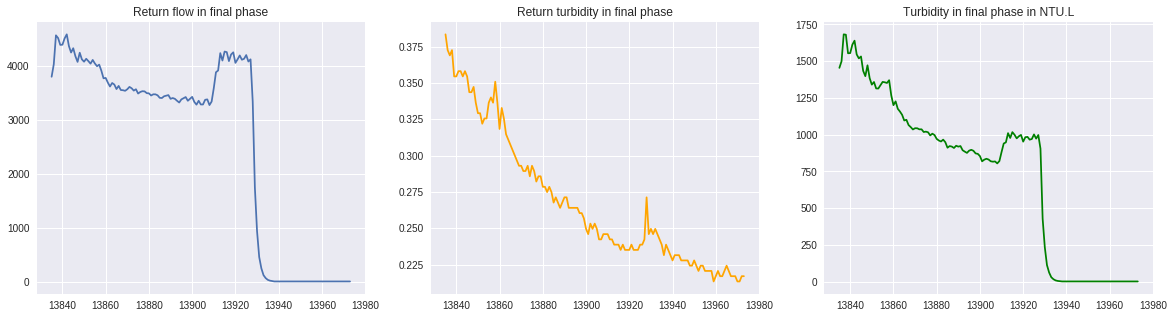

In [25]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

In [39]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [40]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

### Удалим из тренировочной выборки записи о последней стадии, так как цель - предсказать помутнение заблаговременно:

In [0]:
train_data = train_data[train_data['phase'] != 'final_rinse']

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

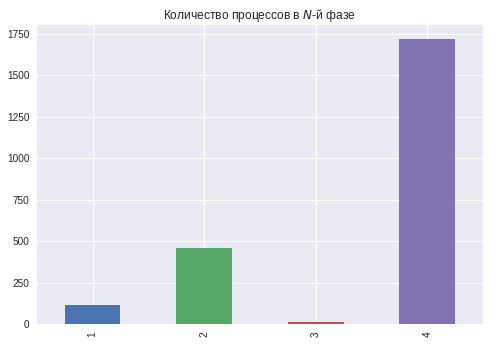

In [42]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

### Создадим уникальный индентификатор фазы для каждого процесса:


In [0]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 80% of phases to keep
rng = np.random.RandomState(2019)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.8),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

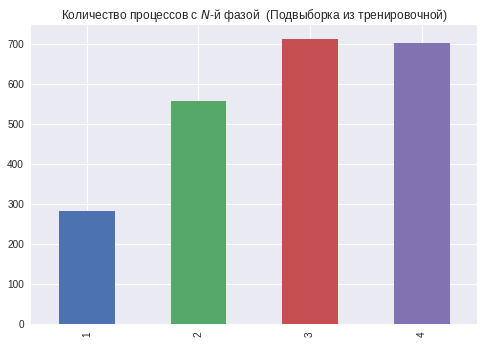

In [46]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

### Feature engineering

In [47]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000))

,pipeline_L3,pipeline_L4,pipeline_L7,pipeline_L12,num_phases
process_id,,,,,
20001,0,1,0,0,4
20002,1,0,0,0,2
20003,1,0,0,0,3
20004,0,0,1,0,2
20005,0,0,1,0,1
20008,0,1,0,0,2


In [0]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

In [49]:
def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols].set_index('process_id')
    
    # create features: min, max, mean, standard deviation, and mean of the last five observations
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', lambda x: x.tail(5).mean()])
    
    return ts_features

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

supply_flow                                                      \
                    min         max          mean           std    <lambda>   
process_id                                                                    
20001         21.701390   59396.703  49501.604051  12445.724586  48618.3452   
20002          7.233796   34295.430  27142.963425   8337.197885  29688.2238   
20003      -1244.213000  103096.070  29902.913654  10872.426632  30179.3980   
20004        -43.402780   49537.035  31117.193119  13046.723480  33796.2958   
20005          0.000000   31295.209  28241.716353   7107.794924  30962.0944   
20008       2723.524400   60980.902  47568.718207  11803.270140  55033.9996   

           supply_pressure                                            ...      \
                       min       max      mean       std  <lambda>    ...       
process_id                                                            ...       
20001            -0.036024  2.223741  1.673456  0.344843  1.204688    ...       
20002            -0.034071  2.170790  1.477925  0.421852  1.552300    ...       
20003            -0.033854  3.855469  2.630566  0.917518  3.092057    ...       
20004            -0.009549  0.482422  0.287865  0.163790  0.343012    ...       
20005            -0.023438  0.487196  0.418469  0.128794  0.468186    ...       
20008            -0.092665  0.174913  0.169046  0.033207  0.174696    ...       

           tank_concentration_caustic                                  \
                                  min        max       mean       std   
process_id                                                              
20001                       44.667377  46.662950  45.266623  0.322050   
20002                       44.773426  46.242180  45.373944  0.253696   
20003                       44.209152  47.086292  45.157076  0.296316   
20004                       44.831688  46.164917  45.176648  0.172123   
20005                       44.638810  46.644493  45.163984  0.471708   
20008                       44.786827  47.464478  45.379763  0.383026   

                      tank_concentration_acid                                  \
             <lambda>                     min        max       mean       std   
process_id                                                                      
20001       45.878381               39.447857  52.411568  44.711593  0.648487   
20002       45.269097               44.216820  44.708210  44.332388  0.079575   
20003       44.669835               43.750900  45.270653  44.503377  0.236661   
20004       45.225381               44.154810  45.862520  44.835026  0.485012   
20005       45.739765               43.527600  44.412254  43.921479  0.249111   
20008       45.185415               44.621710  45.163643  44.808678  0.065374   

                       
             <lambda>  
process_id             
20001       44.653038  
20002       44.229616  
20003       44.716846  
20004       45.226021  
20005       43.952939  
20008       45.012828  

[6 rows x 75 columns]

In [0]:
def create_feature_matrix(df):
    metadata = prep_metadata(df)
    time_series = prep_time_series_features(df)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    return feature_matrix

In [0]:
train_features = create_feature_matrix(train_limited)

In [52]:
train_features.head()

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,...,"(tank_concentration_caustic, min)","(tank_concentration_caustic, max)","(tank_concentration_caustic, mean)","(tank_concentration_caustic, std)","(tank_concentration_caustic, <lambda>)","(tank_concentration_acid, min)","(tank_concentration_acid, max)","(tank_concentration_acid, mean)","(tank_concentration_acid, std)","(tank_concentration_acid, <lambda>)"
process_id,,,,,,,,,,,,,,,,,,,,,
20001,0,0,0,0,0,0,1,0,0,0,...,44.667377,46.662950,45.266623,0.322050,45.878381,39.447857,52.411568,44.711593,0.648487,44.653038
20002,0,0,0,0,0,1,0,0,0,0,...,44.773426,46.242180,45.373944,0.253696,45.269097,44.216820,44.708210,44.332388,0.079575,44.229616
20003,0,0,0,0,0,1,0,0,0,0,...,44.209152,47.086292,45.157076,0.296316,44.669835,43.750900,45.270653,44.503377,0.236661,44.716846
20004,0,0,0,0,0,0,0,0,1,0,...,44.831688,46.164917,45.176648,0.172123,45.225381,44.154810,45.862520,44.835026,0.485012,45.226021
20005,0,0,0,0,0,0,0,0,1,0,...,44.638810,46.644493,45.163984,0.471708,45.739765,43.527600,44.412254,43.921479,0.249111,43.952939


# Строим модели и тестируем их:

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)

rf_regressor = RandomForestRegressor(n_estimators=115, random_state=13, n_jobs=-1, 
                                     max_depth=23,
                                     max_leaf_nodes= 100,
                                     min_samples_leaf = 5,
                                     
      
                                    #max_features=17,
                                   # criterion = 'mse',
                                  
                                    )

#sgd_regr = SGDRegressor(penalty='elasticnet', penalty='l1')

In [54]:
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
           max_features='auto', max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

**Напишем функцию, которая считает ошибку предсказания:**

In [0]:

def mean_abs_percentage_err(y_pred, y_true):
  return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))
    

In [56]:
mean_abs_percentage_err(rf_regressor.predict(X_test), y_test) - 1.3955445450544135

0.17551018709861066

In [57]:
rf_regressor.fit(train_features, np.ravel(train_labels))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
           max_features='auto', max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [0]:
test_features = create_feature_matrix(test_data)

In [0]:
preds = rf_regressor.predict(test_features)

In [0]:
submission_format = pd.read_csv('submission_format.csv', index_col=0)

In [0]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [0]:
my_submission.to_csv('first_try_to_beat_benchmark.csv')